In [5]:
import os

if os.path.exists('mta_data.db'):
    os.remove('mta_data.db')
    
# get MTA data from same summer as satellite image
import get_mta

%run get_mta "17"


52 weeks to collect:

['2017-12-30', '2017-12-23', '2017-12-16', '2017-12-09', '2017-12-02', '2017-11-25', '2017-11-18', '2017-11-11', '2017-11-04', '2017-10-28', '2017-10-21', '2017-10-14', '2017-10-07', '2017-09-30', '2017-09-23', '2017-09-16', '2017-09-09', '2017-09-02', '2017-08-26', '2017-08-19', '2017-08-12', '2017-08-05', '2017-07-29', '2017-07-22', '2017-07-15', '2017-07-08', '2017-07-01', '2017-06-24', '2017-06-17', '2017-06-10', '2017-06-03', '2017-05-27', '2017-05-20', '2017-05-13', '2017-05-06', '2017-04-29', '2017-04-22', '2017-04-15', '2017-04-08', '2017-04-01', '2017-03-25', '2017-03-18', '2017-03-11', '2017-03-04', '2017-02-25', '2017-02-18', '2017-02-11', '2017-02-04', '2017-01-28', '2017-01-21', '2017-01-14', '2017-01-07']

Continue? (y/n) y

Connecting to (or creating) mta_data SQLite database ...

Week: 2017-12-30 -- Getting data ...
Week: 2017-12-30 -- Inserting into SQLite ...
Week: 2017-12-23 -- Getting data ...
Week: 2017-12-23 -- Inserting into SQLite ...
Week

In [1]:
#TODO: need to clean this up, remove things I don't end up using
import os

import sqlite3 as sq
from sqlalchemy import create_engine, inspect, Table, MetaData
from sqlalchemy.orm import sessionmaker

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


In [2]:
mta_data_engine = create_engine("sqlite:///mta_data.db")


In [3]:
def insert_table_from_csv(csv_list, engine):
    for file in csv_list:
        with open(file, 'r') as f:
            data = pd.read_csv(f)
            data.columns = data.columns.str.strip()
        data.to_sql(os.path.splitext(file)[0], con=mta_data_engine, index=False, if_exists='replace')
    

In [4]:
insert_table_from_csv(['geocoded.csv'], mta_data_engine)


In [5]:
insp = inspect(mta_data_engine)
print(insp.get_table_names())


['geocoded', 'mta_data']


In [ ]:
pd.read_sql('''
            ALTER TABLE mta_data 
            RENAME COLUMN "C/A" TO "BOOTH";
            ''',
            mta_data_engine);


In [72]:
mta_df = pd.read_sql('''
            SELECT a.booth, a.unit, a.scp, a.station, a.linename, a.division,
              a.date, a.time,
              (a.date || ' ' || a.time) AS DATE_TIME,
              a.entries, a.exits,
              b.lat AS LAT, b.lon AS LON,
              (CASE
                WHEN b.lat IS NULL THEN 'True'
                ELSE 'False'
              END) AS LOC_FLAG
            FROM mta_data a
            LEFT JOIN geocoded b
            ON a.booth = b.booth AND a.unit = b.unit
            WHERE a.date >= '06/01/2017' 
              AND a.date <= '08/31/2017' 
              AND a.desc = 'REGULAR';
            ''', 
            mta_data_engine)


In [73]:
mta_df.head()

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,08/26/2017 00:00:00,6303202,2133729,40.762796,-73.967686,False
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,08/26/2017 04:00:00,6303225,2133730,40.762796,-73.967686,False
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,08/26/2017 08:00:00,6303237,2133753,40.762796,-73.967686,False
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,08/26/2017 12:00:00,6303309,2133830,40.762796,-73.967686,False
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,08/26/2017 16:00:00,6303508,2133882,40.762796,-73.967686,False


In [74]:
mta_df['DATE_TIME'] = pd.to_datetime(mta_df.DATE_TIME, format = '%m/%d/%Y %H:%M:%S')

bools = {'True': True, 'False': False}
mta_df['LOC_FLAG'] = mta_df['LOC_FLAG'].map(bools)


In [75]:
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2594142 entries, 0 to 2594141
Data columns (total 14 columns):
 #   Column     Dtype         
---  ------     -----         
 0   BOOTH      object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       object        
 7   TIME       object        
 8   DATE_TIME  datetime64[ns]
 9   ENTRIES    int64         
 10  EXITS      int64         
 11  LAT        float64       
 12  LON        float64       
 13  LOC_FLAG   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 259.8+ MB


In [12]:
mta_df['DAILY_ENTRIES'] = mta_df.groupby(['BOOTH', 'UNIT', 'SCP', 'STATION', 'DATE']).ENTRIES.transform(max)


In [13]:
mta_df.head(10)

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,DAILY_ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,00:00:00,2017-08-26 00:00:00,6303202,2133729,40.762796,-73.967686,False,6303739
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,2017-08-26 04:00:00,6303225,2133730,40.762796,-73.967686,False,6303739
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,2017-08-26 08:00:00,6303237,2133753,40.762796,-73.967686,False,6303739
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,2017-08-26 12:00:00,6303309,2133830,40.762796,-73.967686,False,6303739
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,2017-08-26 16:00:00,6303508,2133882,40.762796,-73.967686,False,6303739
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,20:00:00,2017-08-26 20:00:00,6303739,2133926,40.762796,-73.967686,False,6303739
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,00:00:00,2017-08-27 00:00:00,6303877,2133946,40.762796,-73.967686,False,6304278
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,04:00:00,2017-08-27 04:00:00,6303900,2133949,40.762796,-73.967686,False,6304278
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,08:00:00,2017-08-27 08:00:00,6303908,2133965,40.762796,-73.967686,False,6304278
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,12:00:00,2017-08-27 12:00:00,6303971,2134024,40.762796,-73.967686,False,6304278


In [14]:
mta_df[['PREV_DATE', 'PREV_ENTRIES']] = mta_df.groupby(['BOOTH', 'UNIT', 'SCP', 'STATION'])[['DATE', 'ENTRIES']].shift(1)


In [44]:
mta_df

,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,DAILY_ENTRIES,PREV_DATE,PREV_ENTRIES,HOURLY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,2017-08-26 04:00:00,6303225,2133730,40.762796,-73.967686,False,6303739,08/26/2017,6303202.0,23.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,2017-08-26 08:00:00,6303237,2133753,40.762796,-73.967686,False,6303739,08/26/2017,6303225.0,12.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,2017-08-26 12:00:00,6303309,2133830,40.762796,-73.967686,False,6303739,08/26/2017,6303237.0,72.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,2017-08-26 16:00:00,6303508,2133882,40.762796,-73.967686,False,6303739,08/26/2017,6303309.0,199.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,20:00:00,2017-08-26 20:00:00,6303739,2133926,40.762796,-73.967686,False,6303739,08/26/2017,6303508.0,231.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594137,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/02/2017,05:00:00,2017-06-02 05:00:00,5554,299,40.757400,-73.954006,False,5554,06/02/2017,5554.0,0.0
2594138,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/02/2017,09:00:00,2017-06-02 09:00:00,5554,299,40.757400,-73.954006,False,5554,06/02/2017,5554.0,0.0
2594139,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/02/2017,13:00:00,2017-06-02 13:00:00,5554,299,40.757400,-73.954006,False,5554,06/02/2017,5554.0,0.0
2594140,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/02/2017,17:00:00,2017-06-02 17:00:00,5554,299,40.757400,-73.954006,False,5554,06/02/2017,5554.0,0.0


In [45]:
mta_df.dropna(subset=['PREV_DATE'], axis=0, inplace=True)
mta_df.reset_index(inplace=True)


In [53]:
# 14400 seconds in 4 hours, maximum of 3 people per turnstile per second as an upper limit
pps = 3
mta_df['HOURLY_ENTRIES'] = [np.abs(entries - mta_df['PREV_ENTRIES'][i]) if (np.abs(entries - mta_df['PREV_ENTRIES'][i]) < 14400*pps) else 14400*pps for i,entries in enumerate(mta_df['ENTRIES'])]


43200.0 0.0


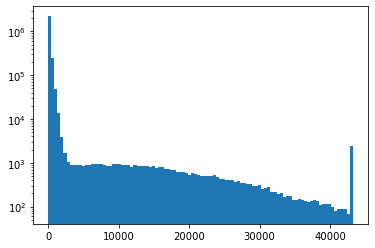

In [54]:
plt.hist(mta_df['HOURLY_ENTRIES'], bins=100)
plt.yscale('log')
print(max(mta_df['HOURLY_ENTRIES']), min(mta_df['HOURLY_ENTRIES']))


In [55]:
(mta_df['HOURLY_ENTRIES']).describe()


count    2.589423e+06
mean     5.092089e+02
std      2.807454e+03
min      0.000000e+00
25%      1.100000e+01
50%      8.300000e+01
75%      2.610000e+02
max      4.320000e+04
Name: HOURLY_ENTRIES, dtype: float64

In [58]:
mta_df.head(15)


,index,BOOTH,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DATE_TIME,ENTRIES,EXITS,LAT,LON,LOC_FLAG,DAILY_ENTRIES,PREV_DATE,PREV_ENTRIES,HOURLY_ENTRIES
0,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,04:00:00,2017-08-26 04:00:00,6303225,2133730,40.762796,-73.967686,False,6303739,08/26/2017,6303202.0,23.0
1,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,08:00:00,2017-08-26 08:00:00,6303237,2133753,40.762796,-73.967686,False,6303739,08/26/2017,6303225.0,12.0
2,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,12:00:00,2017-08-26 12:00:00,6303309,2133830,40.762796,-73.967686,False,6303739,08/26/2017,6303237.0,72.0
3,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,16:00:00,2017-08-26 16:00:00,6303508,2133882,40.762796,-73.967686,False,6303739,08/26/2017,6303309.0,199.0
4,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/26/2017,20:00:00,2017-08-26 20:00:00,6303739,2133926,40.762796,-73.967686,False,6303739,08/26/2017,6303508.0,231.0
5,6,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,00:00:00,2017-08-27 00:00:00,6303877,2133946,40.762796,-73.967686,False,6304278,08/26/2017,6303739.0,138.0
6,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,04:00:00,2017-08-27 04:00:00,6303900,2133949,40.762796,-73.967686,False,6304278,08/27/2017,6303877.0,23.0
7,8,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,08:00:00,2017-08-27 08:00:00,6303908,2133965,40.762796,-73.967686,False,6304278,08/27/2017,6303900.0,8.0
8,9,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,12:00:00,2017-08-27 12:00:00,6303971,2134024,40.762796,-73.967686,False,6304278,08/27/2017,6303908.0,63.0
9,10,A002,R051,02-00-00,59 ST,NQR456W,BMT,08/27/2017,16:00:00,2017-08-27 16:00:00,6304096,2134074,40.762796,-73.967686,False,6304278,08/27/2017,6303971.0,125.0


In [81]:
for i, group in mta_df[mta_df['LOC_FLAG'] == True].groupby('STATION'):
    print(i)


34 ST-HUDSON YD
63 DR-REGO PARK
72 ST-2 AVE
86 ST-2 AVE
96 ST
96 ST-2 AVE
9TH STREET
ATL AV-BARCLAY
CHRISTOPHER ST
CITY / BUS
CORTLANDT ST
FULTON ST
LACKAWANNA
LEXINGTON AV/63
NEWARK BM BW
NEWARK C
NEWARK HM HE
NEWARK HW BMEBE
PATH NEW WTC
PAVONIA/NEWPORT
SOUTH FERRY
THIRTY ST


In [82]:
for i, group in mta_df[mta_df['LOC_FLAG'] == False].groupby('STATION'):
    print(i)

1 AV
103 ST
103 ST-CORONA
104 ST
110 ST
111 ST
116 ST
116 ST-COLUMBIA
121 ST
125 ST
135 ST
137 ST CITY COL
138/GRAND CONC
14 ST
14 ST-UNION SQ
145 ST
149/GRAND CONC
14TH STREET
15 ST-PROSPECT
155 ST
157 ST
161/YANKEE STAD
163 ST-AMSTERDM
167 ST
168 ST
169 ST
170 ST
174 ST
174-175 STS
175 ST
176 ST
18 AV
18 ST
181 ST
182-183 STS
183 ST
190 ST
191 ST
2 AV
20 AV
207 ST
21 ST
21 ST-QNSBRIDGE
215 ST
219 ST
225 ST
23 ST
231 ST
233 ST
238 ST
25 AV
25 ST
28 ST
3 AV
3 AV 138 ST
3 AV-149 ST
30 AV
33 ST
33 ST-RAWSON ST
34 ST-HERALD SQ
34 ST-PENN STA
36 AV
36 ST
39 AV
4 AV-9 ST
40 ST LOWERY ST
42 ST-BRYANT PK
42 ST-PORT AUTH
45 ST
46 ST
46 ST BLISS ST
47-50 STS ROCK
49 ST
4AV-9 ST
5 AV/53 ST
5 AV/59 ST
5 AVE
50 ST
51 ST
52 ST
55 ST
57 ST
57 ST-7 AV
59 ST
59 ST COLUMBUS
6 AV
61 ST WOODSIDE
63 DR-REGO PARK
65 ST
66 ST-LINCOLN
67 AV
68ST-HUNTER CO
69 ST
7 AV
71 ST
72 ST
74 ST-BROADWAY
75 AV
75 ST-ELDERTS
77 ST
79 ST
8 AV
8 ST-NYU
80 ST
81 ST-MUSEUM
82 ST-JACKSON H
85 ST-FOREST PK
86 ST
88 ST
9 AV
90 